In [2]:
#Attach packages, read in data
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

players <- read_csv("Data/players.csv")
head(players)

#sessions <- read_csv("Data/sessions.csv")
#head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Check for github

In [3]:
#Tidy the data for later steps
players_clean <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(!played_hours == 0, !Age == "NA") 

summary(players_clean)

  experience        subscribe  hashedEmail         played_hours   
 Length:109         FALSE:25   Length:109         Min.   :  0.10  
 Class :character   TRUE :84   Class :character   1st Qu.:  0.10  
 Mode  :character              Mode  :character   Median :  0.50  
                                                  Mean   : 10.51  
                                                  3rd Qu.:  1.80  
                                                  Max.   :223.10  
     name              gender               Age      
 Length:109         Length:109         Min.   : 9.0  
 Class :character   Class :character   1st Qu.:17.0  
 Mode  :character   Mode  :character   Median :20.0  
                                       Mean   :21.3  
                                       3rd Qu.:23.0  
                                       Max.   :58.0  

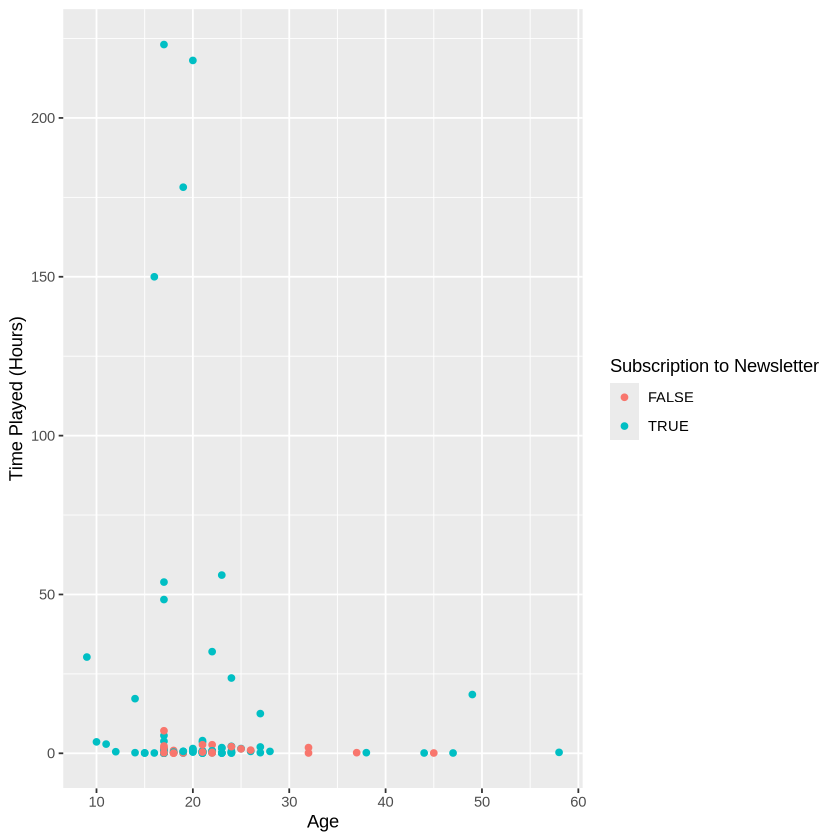

In [4]:
#Check for obvious relationship

players_select <- players_clean |>
    select(Age, subscribe, played_hours)

players_plot <- players_select |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe))+
    geom_point()+
    labs(x = "Age", y = "Time Played (Hours)", color = "Subscription to Newsletter")
players_plot

In [5]:
#Split the data into training and testing
subscribe_split <- initial_split(players_select, prop = 0.75, strata = subscribe)

subscribe_training <- training(subscribe_split)
subscribe_testing <- testing(subscribe_split)

In [6]:
#Specification and Recipe for KNN Regression
subscribe_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

subscribe_recipe <- recipe(subscribe ~ Age + played_hours, data = subscribe_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

subscribe_vfold <- vfold_cv(data = subscribe_training, v = 5, strata = subscribe)

gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 10))

In [9]:
#Find the best k value for knn classification using collect_metrics

subscribe_results <- workflow()|>
    add_recipe(subscribe_recipe)|>
    add_model(subscribe_spec)|>
    tune_grid(resamples = subscribe_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "accuracy")

subscribe_results

→ A | warning: 81 samples were requested but there were 64 rows in the data. 59 will be used.

There were issues with some computations   A: x1

→ B | warning: No event observations were detected in `truth` with event level 'FALSE'.

There were issues with some computations   A: x1
There were issues with some computations   A: x2   B: x1

→ C | error:   ℹ In index: 8.
               Caused by error in `[.default`:
               ! only 0's may be mixed with negative subscripts

There were issues with some computations   A: x2   B: x1
→ D | warning: 81 samples were requested but there were 66 rows in the data. 61 will be used.

There were issues with some computations   A: x2   B: x1
There were issues with some computations   A: x3   B: x2   C: x3   D: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6176471,2,0.02941176,Preprocessor1_Model1
11,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model2
21,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model3
31,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model4
41,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model5
51,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model6
61,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model7
71,accuracy,binary,0.2352941,2,0.00000000,Preprocessor1_Model8
81,accuracy,binary,0.7647059,2,0.00000000,Preprocessor1_Model9


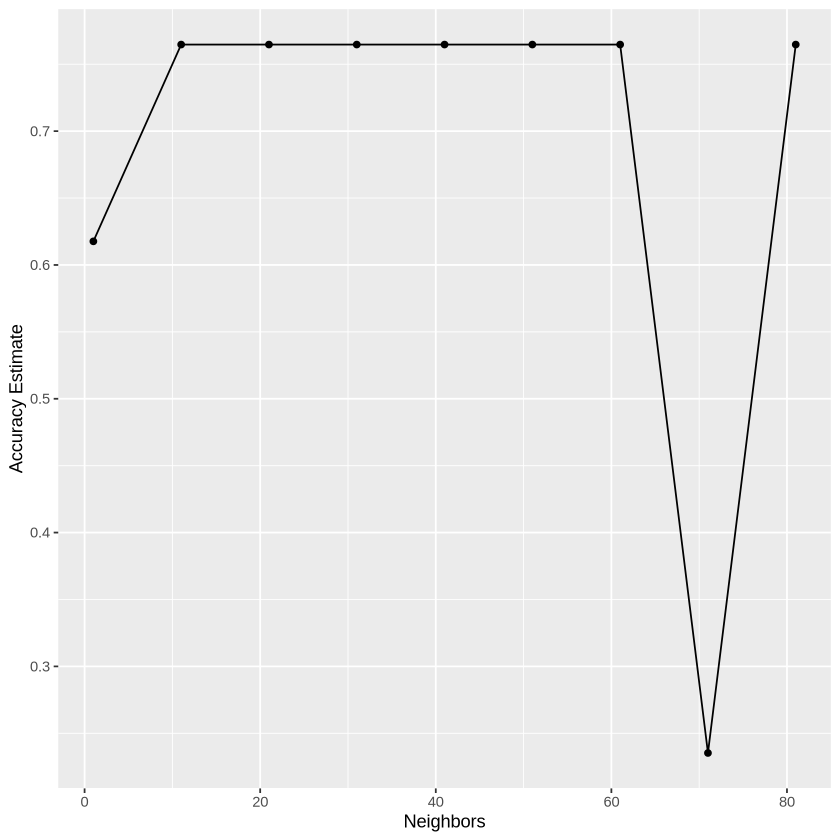

In [12]:
#Plot the results from the last cell and use the elbow to find the best k value
elbow_plot <- subscribe_results |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") 
                       
elbow_plot